In [1]:
from blendinator.models.proba_unet import ProbaUNet
import numpy as np
from astropy.io import fits
import tensorflow as tf

# from train import train
from predict import predict
from predict import summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tensorflow.keras as tfk


%load_ext autoreload
%autoreload 2
print(f"tf:{tf.__version__}")

tf:2.2.0


In [2]:
def asinh_norm(x, y):
    return tf.asinh(tf.divide(x, tf.math.reduce_max(x))), y


In [3]:
# """ Training Parameters """
# base_channels = 32
# list_channels = [base_channels, 2*base_channels, 4*base_channels,
#                 6*base_channels, 6*base_channels, 6*base_channels, 6*base_channels]    # List of the filters to do both in the Unet and the proba part
nb_epochs = 5
batch_size = 32
lrs = np.zeros(nb_epochs) + 1.e-4 # 1e-3 * np.exp(-0.1 * np.arange(nb_epochs))
betas = np.ones(nb_epochs)

eval_every_n_step = 200

In [4]:
""" Import and preprocess data (for me, segs = ground truth)"""
local_path = 'checkpoints/'
tycho_path = "./data/checkpoints/check_test"

checkpoint_path = local_path

local_path = './data/'
tycho_path = '/data/hbretonniere/Euclid/fvae_emulated/deblendingstamps_and_seg.fits'

data_path = local_path

name = 'deblendingstamps_and_seg.fits'  # there is 148996 stamps
# checkpoint_path = "/data57/hbretonniere/deblending/tf2/checkpoints_deblendator/"
# print("checkpoint path : ", checkpoint_path)

""" Import data """
data = fits.open(data_path + name)[0].data
imgs = np.expand_dims(data[0], axis=-1).astype('float32')
segs = np.expand_dims(data[1], axis=-1)


train_slice = int(0.8 * imgs.shape[0])
eval_slice = int(0.9 * imgs.shape[0])
train_steps_per_epoch = int(train_slice / batch_size)

train_data = tf.data.Dataset.from_tensor_slices((imgs[:train_slice], segs[:train_slice])).shuffle(100000, reshuffle_each_iteration=True).map(asinh_norm).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
eval_data = tf.data.Dataset.from_tensor_slices((imgs[train_slice:eval_slice], segs[train_slice:eval_slice])).shuffle(100000, reshuffle_each_iteration=True).map(asinh_norm).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_images = imgs[-30:-20, :, :, :]
test_segs = segs[-30:-20]

print('training images shape : ', imgs[:train_slice].shape)
print('eval images shape : ', imgs[train_slice:eval_slice].shape)
print('test images shape : ', test_images.shape)


training images shape :  (7527, 64, 64, 1)
eval images shape :  (941, 64, 64, 1)
test images shape :  (10, 64, 64, 1)


In [5]:
train_steps_per_epoch* nb_epochs

1175

PUnet, loss=651.7083740234375: 100%|██████████| 235/235 [01:28<00:00,  2.62it/s]
PUnet, loss=651.7083740234375: : 236it [01:28,  2.71it/s]                       
PUnet, loss=545.1416625976562: : 236it [01:29,  2.65it/s]
Epoch: 100%|██████████| 5/5 [07:34<00:00, 90.89s/it]


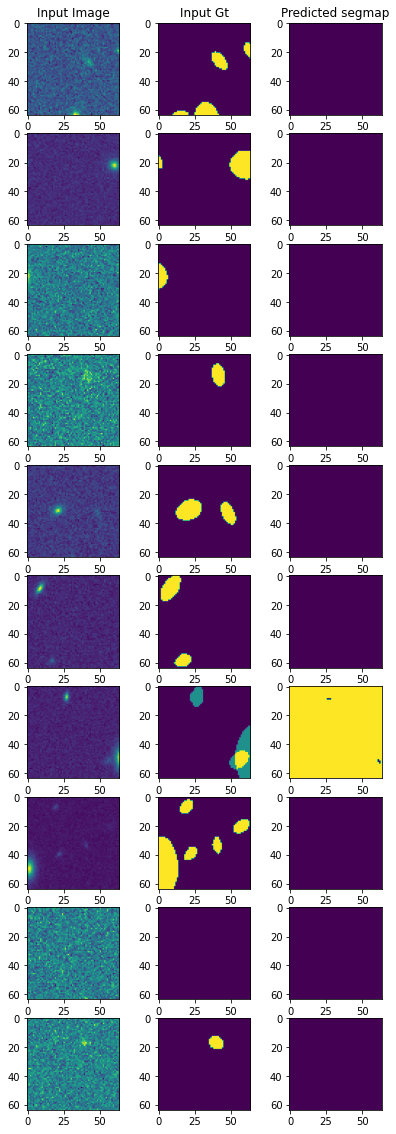

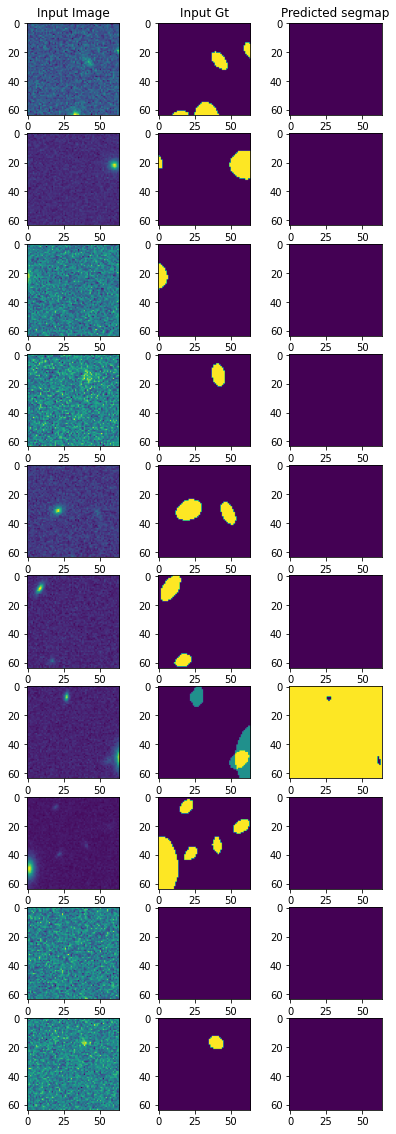

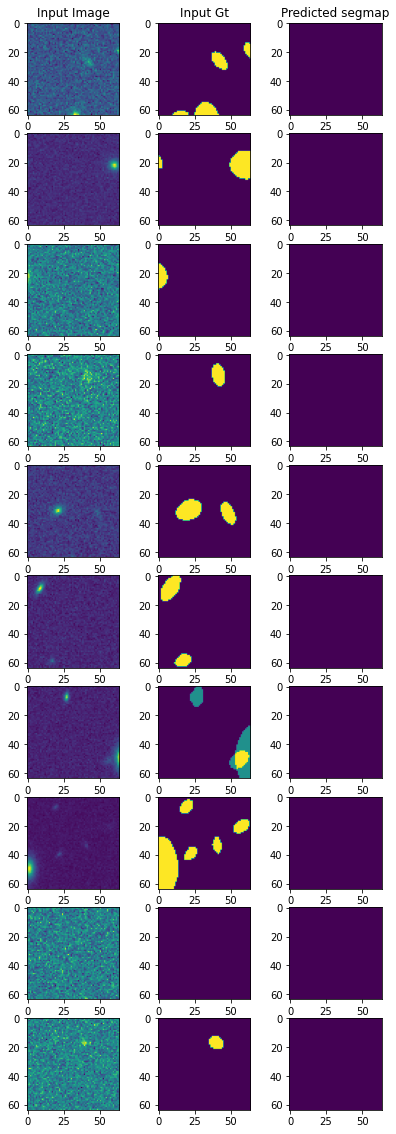

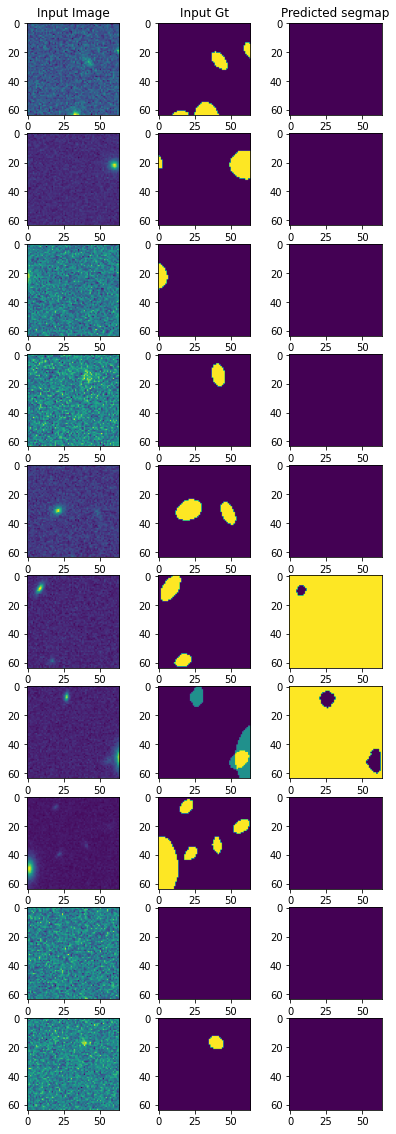

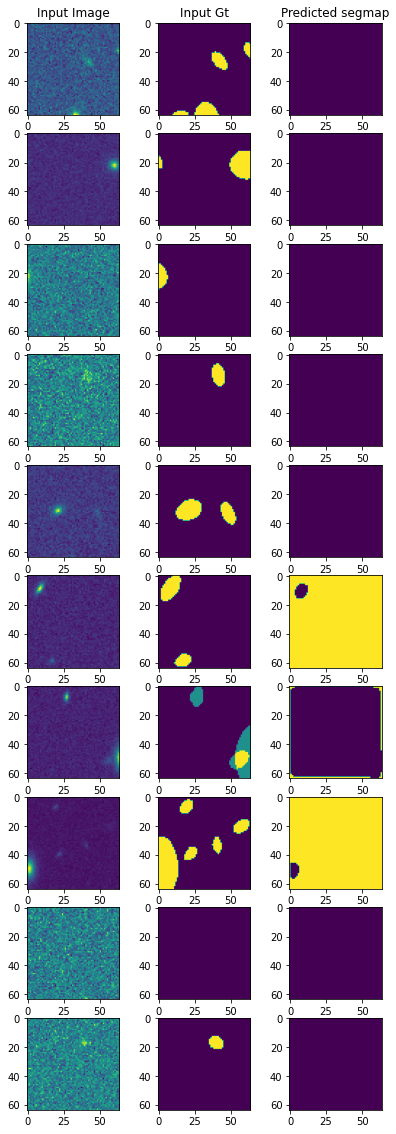

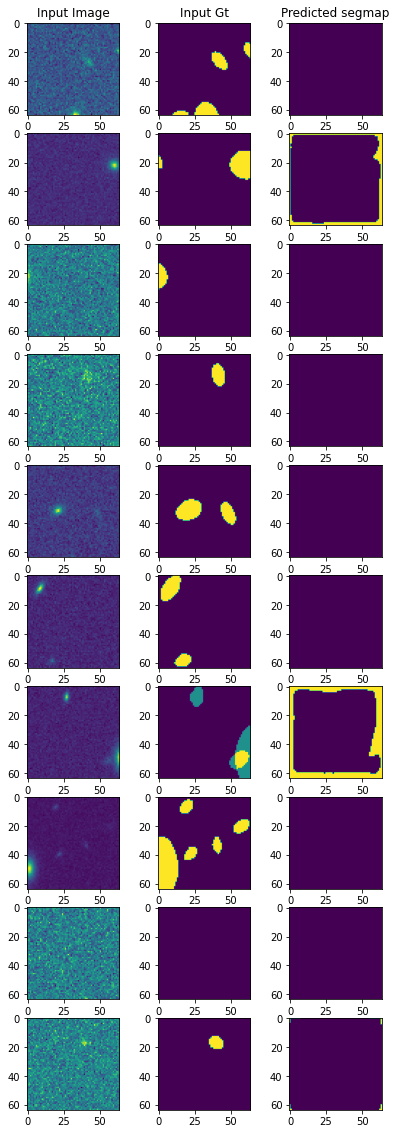

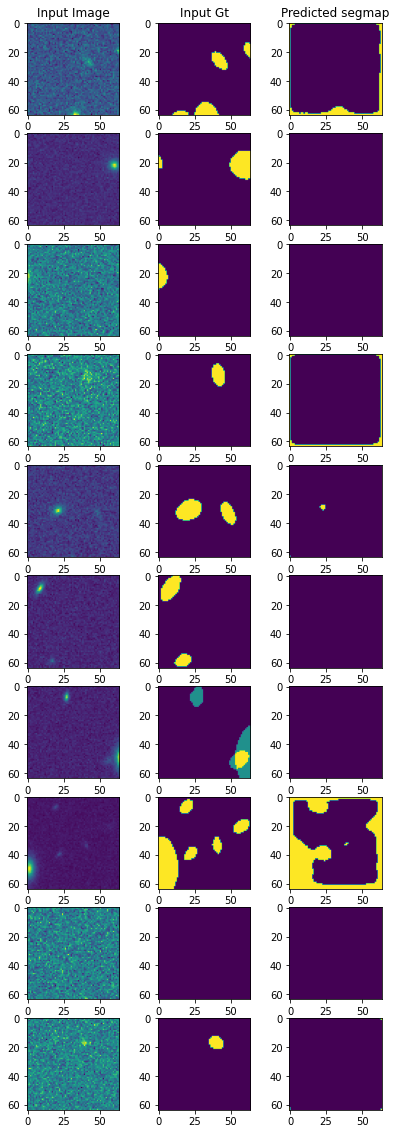

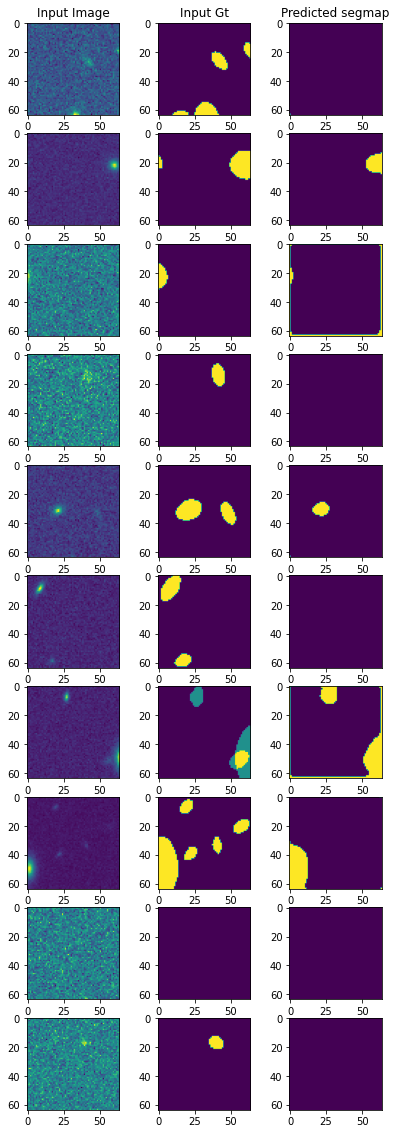

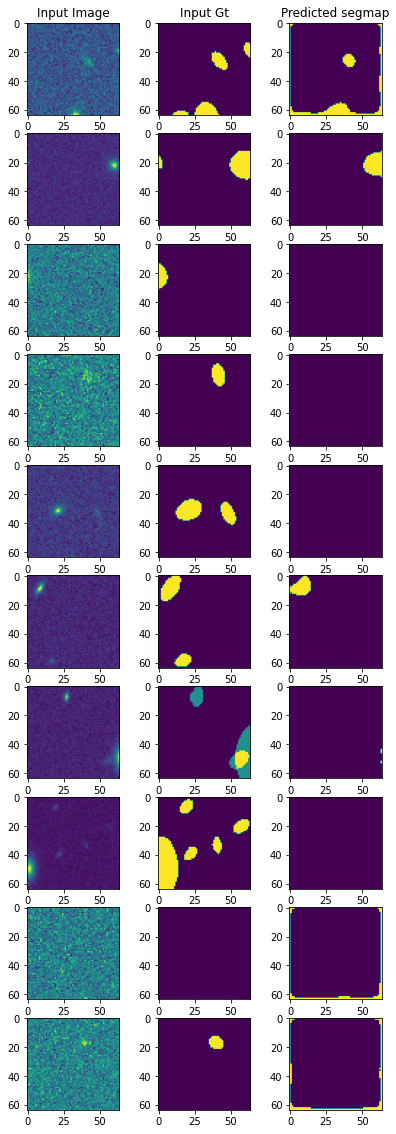

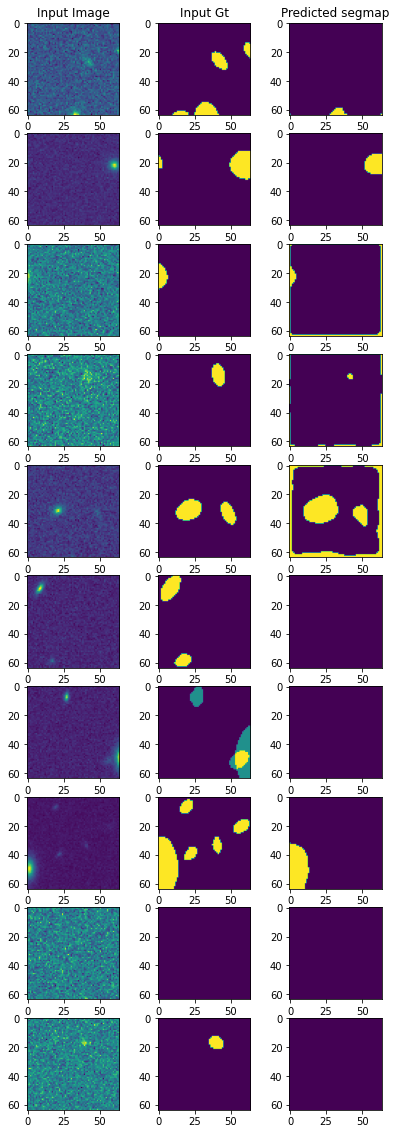

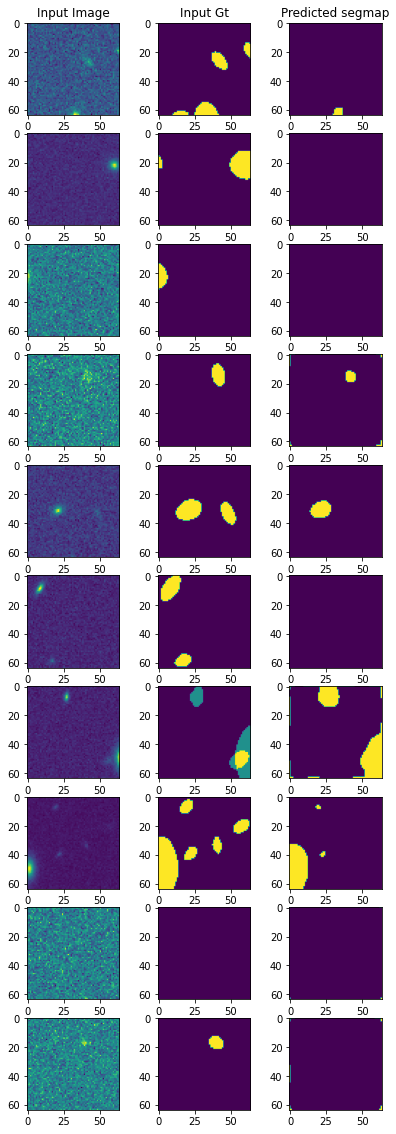

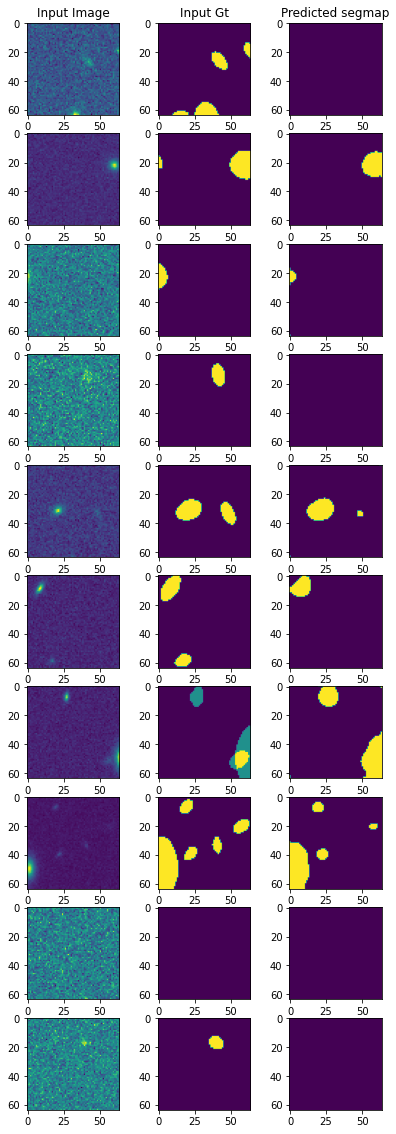

In [10]:
list_channels = [8, 16, 32]
PUNet = ProbaUNet((64, 64, 1), 10, list_channels, 1, 1)
history = [[],[],[]]
history = PUNet.train_and_plot(train_data, [asinh_norm(test_images, test_segs)[0], test_segs], nb_epochs, train_steps_per_epoch, lrs, betas, history, checkpoint_path, [1, 10, 30, 50, 80, 100, 130, 160, 200, 240, 280, 350, 420, 500, 600, 700, 800, train_steps_per_epoch* nb_epochs-10], device='CPU:0')


In [ ]:
list_channels = [8, 16, 32]
PUNet = ProbaUNet((64, 64, 1), 10, list_channels, 1, 1)
history = [[],[],[]]
history = PUNet.train(train_data, nb_epochs, train_steps_per_epoch, lrs, betas, history, checkpoint_path, device='CPU:0')


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].plot(history[0])
ax[0].set_title('Total loss')
ax[0].set_yscale('symlog')

ax[1].plot(history[1])
ax[1].set_yscale('symlog')
ax[1].set_title('Reconstruction loss')

ax[2].plot(history[2])
ax[2].set_yscale('symlog')
ax[2].set_title('KL loss')


In [17]:
PUNet.predict_and_plot(asinh_norm(imgs[-10:], segs[-10:])[0], segs[-10:], 5, 'training')

(64, 64, 3)


TypeError: Invalid shape (64,) for image data

In [29]:
list_channels = [8, 16, 32]
PUNet_r = ProbaUNet((64, 64, 1), 10, list_channels, 1, 1)
PUNet_r.load_weights(checkpoint_path)

()

In [30]:
test_images.shape

(10, 64, 64, 1)

(10, 64, 64, 3)


0

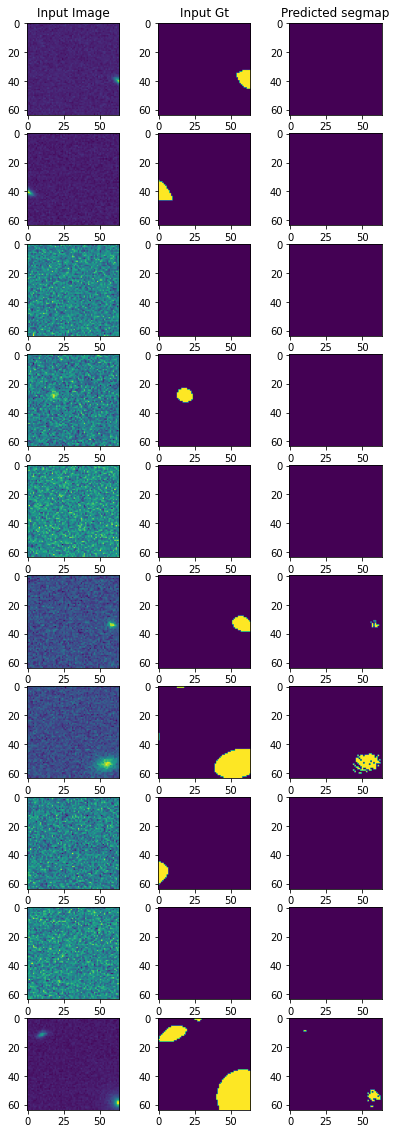

In [34]:
PUNet_r.predict_and_plot(test_images, test_segs, 10, 'predict')

In [14]:
PUNet_restored = ProbaUNet((128, 128, 1), 10, list_channels, 1, 1)
PUNet_restored.load_weights(checkpoint_path)

()

In [66]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np

@tf.function
def predict(PUNet, images, nb_realisation):
    nb_image = images.shape[0]
    predictions = np.zeros((nb_image, nb_realisation, images.shape[1], images.shape[2]))
    for realisation in range(nb_realisation):
        sample = PUNet.prediction_model(images)
        predictions[:, realisation, :, :] = np.argmax(sample.eval, axis=-1) # .eval because of the decorator wich make the function tensorflow graph like
    return predictions

def summary(predictions, threshold_iso, threshold_blend):
    shape = (3,) + (np.shape(predictions)[0],) + np.shape(predictions)[2:]
    print('shape :', shape)
    summaries = np.zeros(shape)
    summaries[0] = np.mean(predictions, axis=1)
    summaries[1] = np.var(predictions, axis=1)
    summaries[2] = np.where(summaries[1]>threshold_iso, 1, 0)
    summaries[2] = np.where(summaries[1]>threshold_blend, 2, summaries[2])
    return(summaries)